In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import joblib
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from config.paths import MODEL_PATHS
import matplotlib.pyplot as plt


plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题



In [2]:
split_file = os.path.join(MODEL_PATHS, "train_val_test_split.pkl")
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(split_file)

# 标签编码
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

print("类别映射:", dict(zip(le.classes_, le.transform(le.classes_))))
print(f"训练样本数: {len(X_train)}, 验证样本数: {len(X_val)}, 测试样本数: {len(X_test)}")


类别映射: {'内圈故障': np.int64(0), '外圈故障': np.int64(1), '正常': np.int64(2), '滚动体故障': np.int64(3)}
训练样本数: 96, 验证样本数: 32, 测试样本数: 33


In [3]:
class BearingDataset(Dataset):
    def __init__(self, features, labels):
        # CNN 输入 (N, C, L)，把特征 reshape 成 (batch, 1, feature_dim)
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


batch_size = 32

train_loader = DataLoader(BearingDataset(X_train, y_train_enc), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(BearingDataset(X_val, y_val_enc), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(BearingDataset(X_test, y_test_enc), batch_size=batch_size, shuffle=False)

print(f"训练 DataLoader 样本数: {len(train_loader.dataset)}")
print(f"验证 DataLoader 样本数: {len(val_loader.dataset)}")
print(f"测试 DataLoader 样本数: {len(test_loader.dataset)}")


训练 DataLoader 样本数: 96
验证 DataLoader 样本数: 32
测试 DataLoader 样本数: 33


In [4]:
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        # 计算全连接层输入维度
        self._to_linear = 64 * (input_dim // 4)  # 两次 maxpool 除以 2
        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train_enc))
model = CNN1D(input_dim, num_classes)

print(model)


CNN1D(
  (conv_layers): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)


In [5]:
import matplotlib.pyplot as plt

def train_model_with_history(model, train_loader, val_loader, num_epochs=50, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    best_model_state = None

    # 保存训练历史
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        # 训练
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        train_loss /= total

        # 验证
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == y_batch).sum().item()
                total_val += y_batch.size(0)
        val_acc = correct_val / total_val

        # 保存历史
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # 加载模型
    model.load_state_dict(best_model_state)
    return model, history


Epoch [1/500] - Train Loss: 1.3304, Train Acc: 0.5000, Val Acc: 0.4688
Epoch [2/500] - Train Loss: 1.2804, Train Acc: 0.5104, Val Acc: 0.4688
Epoch [3/500] - Train Loss: 1.2353, Train Acc: 0.5104, Val Acc: 0.4688
Epoch [4/500] - Train Loss: 1.1867, Train Acc: 0.4792, Val Acc: 0.4688
Epoch [5/500] - Train Loss: 1.1425, Train Acc: 0.4792, Val Acc: 0.4688
Epoch [6/500] - Train Loss: 1.1157, Train Acc: 0.5104, Val Acc: 0.4375
Epoch [7/500] - Train Loss: 1.0892, Train Acc: 0.5104, Val Acc: 0.4688
Epoch [8/500] - Train Loss: 1.0701, Train Acc: 0.5104, Val Acc: 0.4375
Epoch [9/500] - Train Loss: 1.0614, Train Acc: 0.5104, Val Acc: 0.4688
Epoch [10/500] - Train Loss: 1.0500, Train Acc: 0.5104, Val Acc: 0.4688
Epoch [11/500] - Train Loss: 1.0372, Train Acc: 0.5104, Val Acc: 0.4375
Epoch [12/500] - Train Loss: 1.0273, Train Acc: 0.5104, Val Acc: 0.4375
Epoch [13/500] - Train Loss: 1.0009, Train Acc: 0.5104, Val Acc: 0.4375
Epoch [14/500] - Train Loss: 0.9843, Train Acc: 0.5104, Val Acc: 0.4375
E

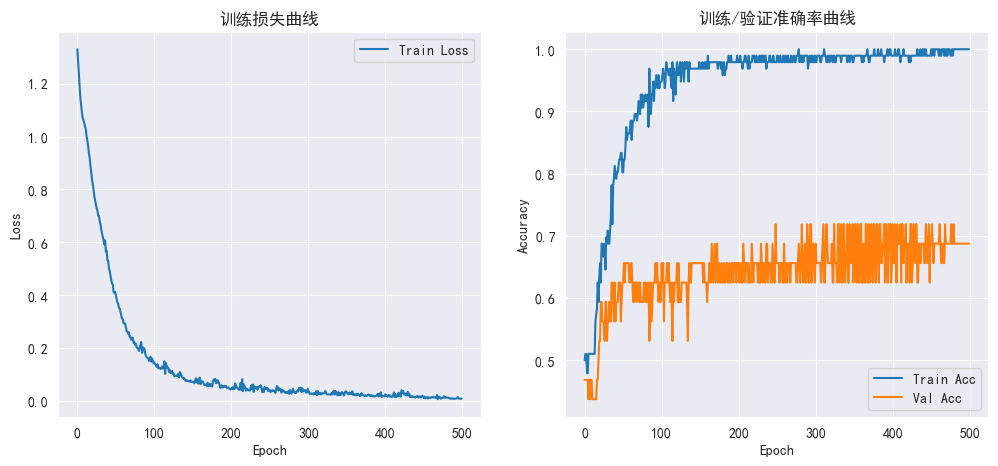

源域模型权重已保存: E:/python_file/TransBearingDiag/src/models\model_src.pth


In [6]:
num_epochs = 500
lr = 1e-3

model, history = train_model_with_history(model, train_loader, val_loader, num_epochs=num_epochs, lr=lr)

# 绘制训练曲线
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("训练损失曲线")
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("训练/验证准确率曲线")
plt.legend()

plt.show()

# ---------- 保存源域模型权重 ----------
src_model_path = os.path.join(MODEL_PATHS, "model_src.pth")
torch.save(model.state_dict(), src_model_path)
print("源域模型权重已保存:", src_model_path)


分类报告：
              precision    recall  f1-score   support

        内圈故障     1.0000    0.6250    0.7692         8
        外圈故障     0.7895    0.9375    0.8571        16
          正常     1.0000    1.0000    1.0000         1
       滚动体故障     0.6250    0.6250    0.6250         8

    accuracy                         0.7879        33
   macro avg     0.8536    0.7969    0.8128        33
weighted avg     0.8070    0.7879    0.7839        33



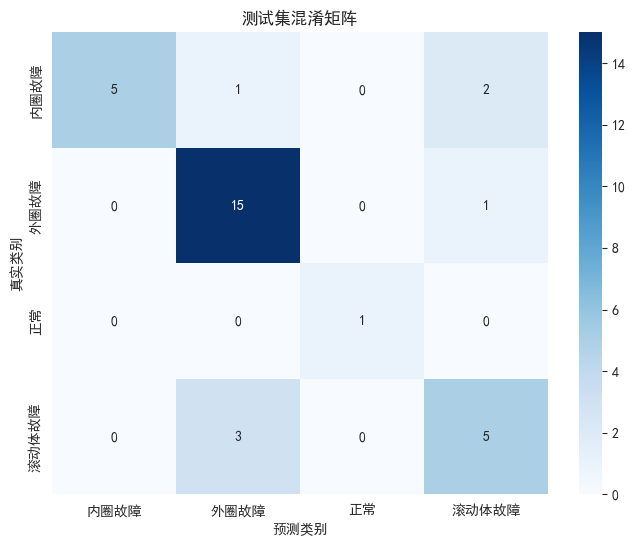

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 分类报告
target_names = le.classes_  # 类别名称
print("分类报告：")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# 混淆矩阵
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("预测类别")
plt.ylabel("真实类别")
plt.title("测试集混淆矩阵")
plt.show()


In [8]:
import os
import joblib
from config.paths import MODEL_PATHS
from sklearn.preprocessing import LabelEncoder


# 加载源域划分好的数据
split_file = os.path.join(MODEL_PATHS, "train_val_test_split.pkl")
X_train_src, X_val_src, X_test_src, y_train_src, y_val_src, y_test_src = joblib.load(split_file)

# 标签编码
le_src = LabelEncoder()
y_train_enc_src = le_src.fit_transform(y_train_src)
y_val_enc_src = le_src.transform(y_val_src)
y_test_enc_src = le_src.transform(y_test_src)



In [9]:
import os
import joblib
from sklearn.preprocessing import LabelEncoder
import torch
from config.paths import MODEL_PATHS

# 加载目标域划分好的数据
split_file = os.path.join(MODEL_PATHS, "train_val_test_split.pkl")
X_train_tgt, X_val_tgt, X_test_tgt, y_train_tgt, y_val_tgt, y_test_tgt = joblib.load(split_file)

# 标签编码
le_tgt = LabelEncoder()
y_train_enc_tgt = le_tgt.fit_transform(y_train_tgt)
y_val_enc_tgt = le_tgt.transform(y_val_tgt)
y_test_enc_tgt = le_tgt.transform(y_test_tgt)

print("目标域类别映射:", dict(zip(le_tgt.classes_, le_tgt.transform(le_tgt.classes_))))


目标域类别映射: {'内圈故障': np.int64(0), '外圈故障': np.int64(1), '正常': np.int64(2), '滚动体故障': np.int64(3)}


In [10]:
input_dim_tgt = X_train_tgt.shape[1]
num_classes_tgt = len(np.unique(y_train_enc_tgt))

model_tgt = CNN1D(input_dim=input_dim_tgt, num_classes=num_classes_tgt)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 仅加载卷积层权重
src_model_path = os.path.join(MODEL_PATHS, "model_src.pth")
pretrained_dict = torch.load(src_model_path, map_location=device)
model_dict = model_tgt.state_dict()

# 只替换卷积层的权重
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and "conv_layers" in k}
model_dict.update(pretrained_dict)
model_tgt.load_state_dict(model_dict)

# 冻结卷积层，只训练全连接层
for param in model_tgt.conv_layers.parameters():
    param.requires_grad = False

model_tgt.to(device)


CNN1D(
  (conv_layers): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [12]:
num_epochs_tgt = 200
lr_tgt = 1e-3

model_tgt, history_tgt = train_model_with_history(
    model_tgt, train_loader, val_loader,
    num_epochs=num_epochs_tgt, lr=lr_tgt
)



Epoch [1/200] - Train Loss: 1.2785, Train Acc: 0.3854, Val Acc: 0.4688
Epoch [2/200] - Train Loss: 1.0736, Train Acc: 0.5000, Val Acc: 0.4688
Epoch [3/200] - Train Loss: 0.9676, Train Acc: 0.5625, Val Acc: 0.4688
Epoch [4/200] - Train Loss: 0.9015, Train Acc: 0.5625, Val Acc: 0.4688
Epoch [5/200] - Train Loss: 0.8344, Train Acc: 0.5833, Val Acc: 0.5000
Epoch [6/200] - Train Loss: 0.7847, Train Acc: 0.7083, Val Acc: 0.4688
Epoch [7/200] - Train Loss: 0.7368, Train Acc: 0.7917, Val Acc: 0.5000
Epoch [8/200] - Train Loss: 0.6851, Train Acc: 0.7708, Val Acc: 0.5625
Epoch [9/200] - Train Loss: 0.6455, Train Acc: 0.7604, Val Acc: 0.5938
Epoch [10/200] - Train Loss: 0.6078, Train Acc: 0.8229, Val Acc: 0.5625
Epoch [11/200] - Train Loss: 0.5655, Train Acc: 0.8542, Val Acc: 0.6250
Epoch [12/200] - Train Loss: 0.5413, Train Acc: 0.8333, Val Acc: 0.6250
Epoch [13/200] - Train Loss: 0.5027, Train Acc: 0.8333, Val Acc: 0.5938
Epoch [14/200] - Train Loss: 0.4901, Train Acc: 0.8750, Val Acc: 0.5625
E

In [13]:
torch.save(model_tgt.state_dict(), os.path.join(MODEL_PATHS, "model_tgt.pth"))
torch.save(model_tgt, os.path.join(MODEL_PATHS,"full_model_tgt.pth")) #完整模型+结构
print("模型权重已保存")


模型权重已保存


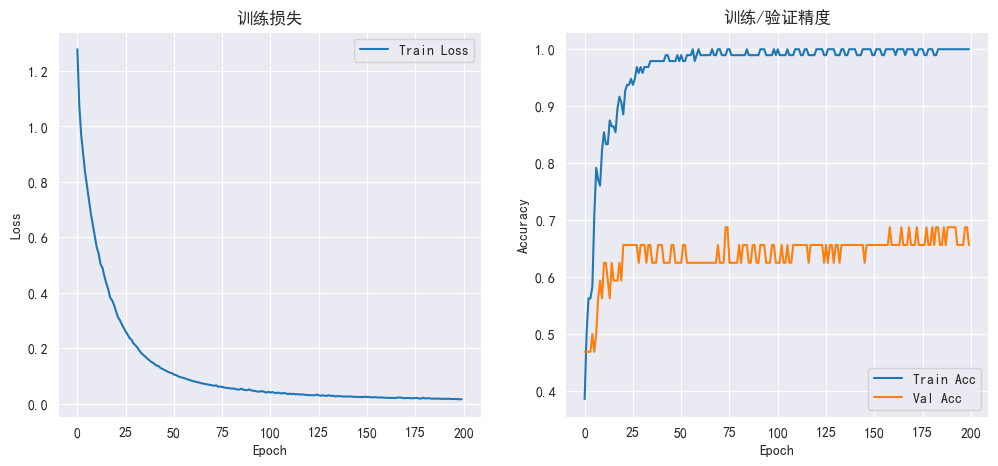

In [14]:
plt.figure(figsize=(12,5))

# 损失曲线
plt.subplot(1,2,1)
plt.plot(history_tgt["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("训练损失")
plt.legend()

# 精度曲线
plt.subplot(1,2,2)
plt.plot(history_tgt["train_acc"], label="Train Acc")
plt.plot(history_tgt["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("训练/验证精度")
plt.legend()

plt.show()


#测试目标域模型

源域模型在源域测试集分类报告：
              precision    recall  f1-score   support

        内圈故障     1.0000    0.6250    0.7692         8
        外圈故障     0.7895    0.9375    0.8571        16
          正常     1.0000    1.0000    1.0000         1
       滚动体故障     0.6250    0.6250    0.6250         8

    accuracy                         0.7879        33
   macro avg     0.8536    0.7969    0.8128        33
weighted avg     0.8070    0.7879    0.7839        33

源域模型在目标域测试集分类报告：
              precision    recall  f1-score   support

        内圈故障     1.0000    0.6250    0.7692         8
        外圈故障     0.7895    0.9375    0.8571        16
          正常     1.0000    1.0000    1.0000         1
       滚动体故障     0.6250    0.6250    0.6250         8

    accuracy                         0.7879        33
   macro avg     0.8536    0.7969    0.8128        33
weighted avg     0.8070    0.7879    0.7839        33

迁移学习后的目标域模型在目标域测试集分类报告：
              precision    recall  f1-score   support

        内圈故障     1

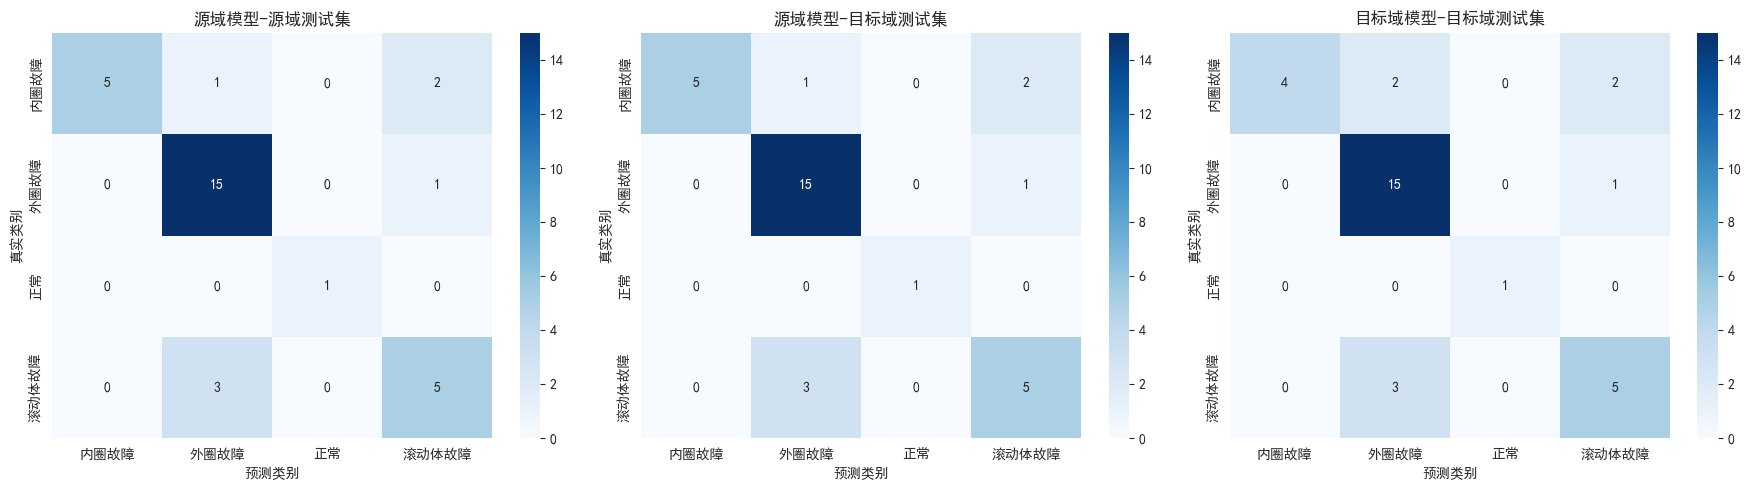

In [15]:
# 测试目标域模型性能
# 对比源域模型与目标域模型在不同测试集上的表现
def evaluate_model(model, X_test, y_test_enc, le, device, batch_size=32):
    model.to(device)
    model.eval()
    y_true, y_pred = [], []
    loader = DataLoader(BearingDataset(X_test, y_test_enc), batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

# 评估源域模型在源域测试集
y_true_src, y_pred_src = evaluate_model(model, X_test, y_test_enc, le, device)
print("源域模型在源域测试集分类报告：")
print(classification_report(y_true_src, y_pred_src, target_names=le.classes_, digits=4))

# 评估源域模型在目标域测试集
y_true_src2tgt, y_pred_src2tgt = evaluate_model(model, X_test_tgt, y_test_enc_tgt, le_tgt, device)
print("源域模型在目标域测试集分类报告：")
print(classification_report(y_true_src2tgt, y_pred_src2tgt, target_names=le_tgt.classes_, digits=4))

# 评估迁移学习后的目标域模型在目标域测试集
y_true_tgt, y_pred_tgt = evaluate_model(model_tgt, X_test_tgt, y_test_enc_tgt, le_tgt, device)
print("迁移学习后的目标域模型在目标域测试集分类报告：")
print(classification_report(y_true_tgt, y_pred_tgt, target_names=le_tgt.classes_, digits=4))

# 绘制混淆矩阵对比
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, y_t, y_p, title, labels in zip(
    axes,
    [y_true_src, y_true_src2tgt, y_true_tgt],
    [y_pred_src, y_pred_src2tgt, y_pred_tgt],
    ["源域模型-源域测试集", "源域模型-目标域测试集", "目标域模型-目标域测试集"],
    [le.classes_, le_tgt.classes_, le_tgt.classes_]
):
    cm = confusion_matrix(y_t, y_p)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("预测类别")
    ax.set_ylabel("真实类别")
    ax.set_title(title)

plt.tight_layout()
plt.show()


In [16]:
# 解冻最后一层卷积层
for name, param in model_tgt.conv_layers.named_parameters():
    if "4" in name:  # 根据CNN层数索引，最后一层卷积索引为4
        param.requires_grad = True

# 再次训练微调
num_epochs_finetune = 100
lr_finetune = 1e-4

model_tgt, history_finetune = train_model_with_history(
    model_tgt, train_loader, val_loader, num_epochs=num_epochs_finetune, lr=lr_finetune
)

Epoch [1/100] - Train Loss: 0.0171, Train Acc: 1.0000, Val Acc: 0.6875
Epoch [2/100] - Train Loss: 0.0163, Train Acc: 1.0000, Val Acc: 0.6875
Epoch [3/100] - Train Loss: 0.0160, Train Acc: 1.0000, Val Acc: 0.6875
Epoch [4/100] - Train Loss: 0.0160, Train Acc: 1.0000, Val Acc: 0.6562
Epoch [5/100] - Train Loss: 0.0160, Train Acc: 1.0000, Val Acc: 0.6562
Epoch [6/100] - Train Loss: 0.0159, Train Acc: 1.0000, Val Acc: 0.6562
Epoch [7/100] - Train Loss: 0.0161, Train Acc: 1.0000, Val Acc: 0.6875
Epoch [8/100] - Train Loss: 0.0157, Train Acc: 1.0000, Val Acc: 0.6875
Epoch [9/100] - Train Loss: 0.0158, Train Acc: 1.0000, Val Acc: 0.6875
Epoch [10/100] - Train Loss: 0.0156, Train Acc: 1.0000, Val Acc: 0.6875
Epoch [11/100] - Train Loss: 0.0157, Train Acc: 1.0000, Val Acc: 0.6875
Epoch [12/100] - Train Loss: 0.0156, Train Acc: 1.0000, Val Acc: 0.6875
Epoch [13/100] - Train Loss: 0.0155, Train Acc: 1.0000, Val Acc: 0.6875
Epoch [14/100] - Train Loss: 0.0158, Train Acc: 1.0000, Val Acc: 0.6562
E

#保存最后微调的模型

In [17]:
import os
from config.paths import MODEL_PATHS

torch.save(model_tgt.state_dict(), os.path.join(MODEL_PATHS, "model_tgt_finetuned.pth"))
torch.save(model_tgt, os.path.join(MODEL_PATHS, "full_model_tgt_finetuned.pth"))
print("微调后的目标域模型已保存")

微调后的目标域模型已保存


绘制微调训练曲线

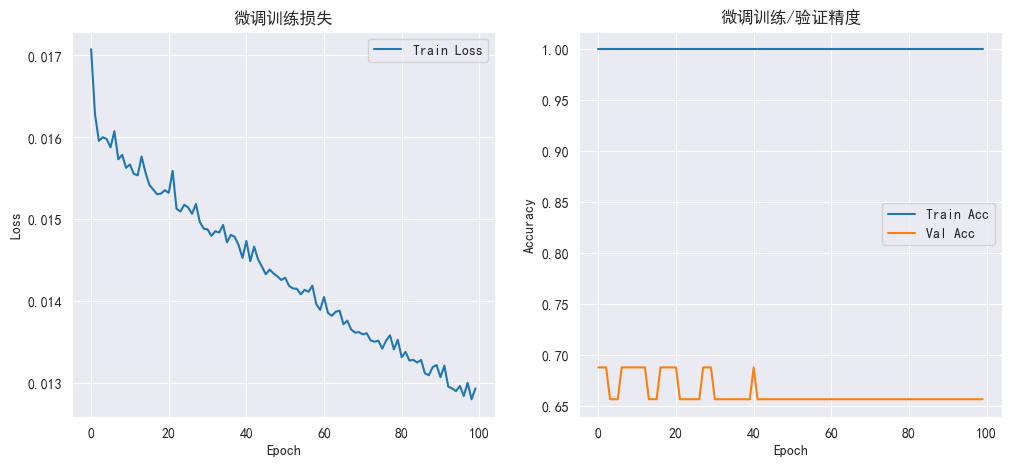

In [18]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_finetune["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("微调训练损失")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_finetune["train_acc"], label="Train Acc")
plt.plot(history_finetune["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("微调训练/验证精度")
plt.legend()

plt.show()


In [19]:
# sample = torch.tensor(X_test_tgt[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
# model_tgt.eval()
# with torch.no_grad():
#     pred = model_tgt(sample)
#     pred_label = le_tgt.inverse_transform([pred.argmax().item()])
# print("样本预测类别:", pred_label[0])

In [20]:
# 目标域 DataLoader
train_loader_tgt = DataLoader(BearingDataset(X_train_tgt, y_train_enc_tgt), batch_size=batch_size, shuffle=True)
val_loader_tgt = DataLoader(BearingDataset(X_val_tgt, y_val_enc_tgt), batch_size=batch_size, shuffle=False)

# 迁移学习训练
model_tgt, history_tgt = train_model_with_history(
    model_tgt,
    train_loader_tgt,  # 使用目标域训练集
    val_loader_tgt,    # 使用目标域验证集
    num_epochs=num_epochs_tgt,
    lr=lr_tgt
)


Epoch [1/200] - Train Loss: 0.0794, Train Acc: 0.9792, Val Acc: 0.6875
Epoch [2/200] - Train Loss: 0.0326, Train Acc: 0.9896, Val Acc: 0.5000
Epoch [3/200] - Train Loss: 0.0615, Train Acc: 0.9792, Val Acc: 0.5000
Epoch [4/200] - Train Loss: 0.0416, Train Acc: 0.9896, Val Acc: 0.6562
Epoch [5/200] - Train Loss: 0.0143, Train Acc: 1.0000, Val Acc: 0.6562
Epoch [6/200] - Train Loss: 0.0124, Train Acc: 1.0000, Val Acc: 0.6250
Epoch [7/200] - Train Loss: 0.0225, Train Acc: 0.9896, Val Acc: 0.6250
Epoch [8/200] - Train Loss: 0.0237, Train Acc: 0.9896, Val Acc: 0.6250
Epoch [9/200] - Train Loss: 0.0197, Train Acc: 0.9896, Val Acc: 0.6250
Epoch [10/200] - Train Loss: 0.0135, Train Acc: 0.9896, Val Acc: 0.6875
Epoch [11/200] - Train Loss: 0.0122, Train Acc: 1.0000, Val Acc: 0.6875
Epoch [12/200] - Train Loss: 0.0133, Train Acc: 1.0000, Val Acc: 0.6562
Epoch [13/200] - Train Loss: 0.0155, Train Acc: 1.0000, Val Acc: 0.6562
Epoch [14/200] - Train Loss: 0.0146, Train Acc: 1.0000, Val Acc: 0.6875
E

绘制迁移学习训练曲线

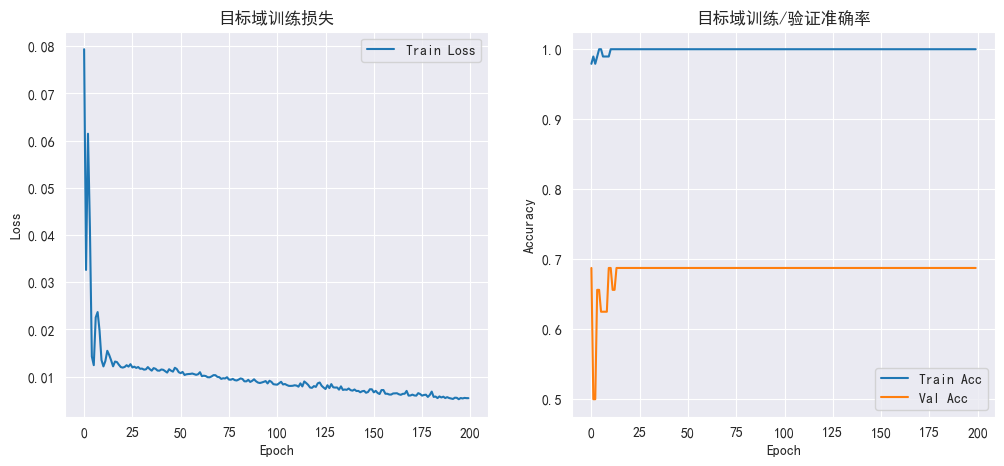

In [21]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history_tgt["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("目标域训练损失")
plt.legend()

# 精度曲线
plt.subplot(1, 2, 2)
plt.plot(history_tgt["train_acc"], label="Train Acc")
plt.plot(history_tgt["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("目标域训练/验证准确率")
plt.legend()

plt.show()


测试集样本索引 0 的预测类别: 滚动体故障
真实类别: 内圈故障


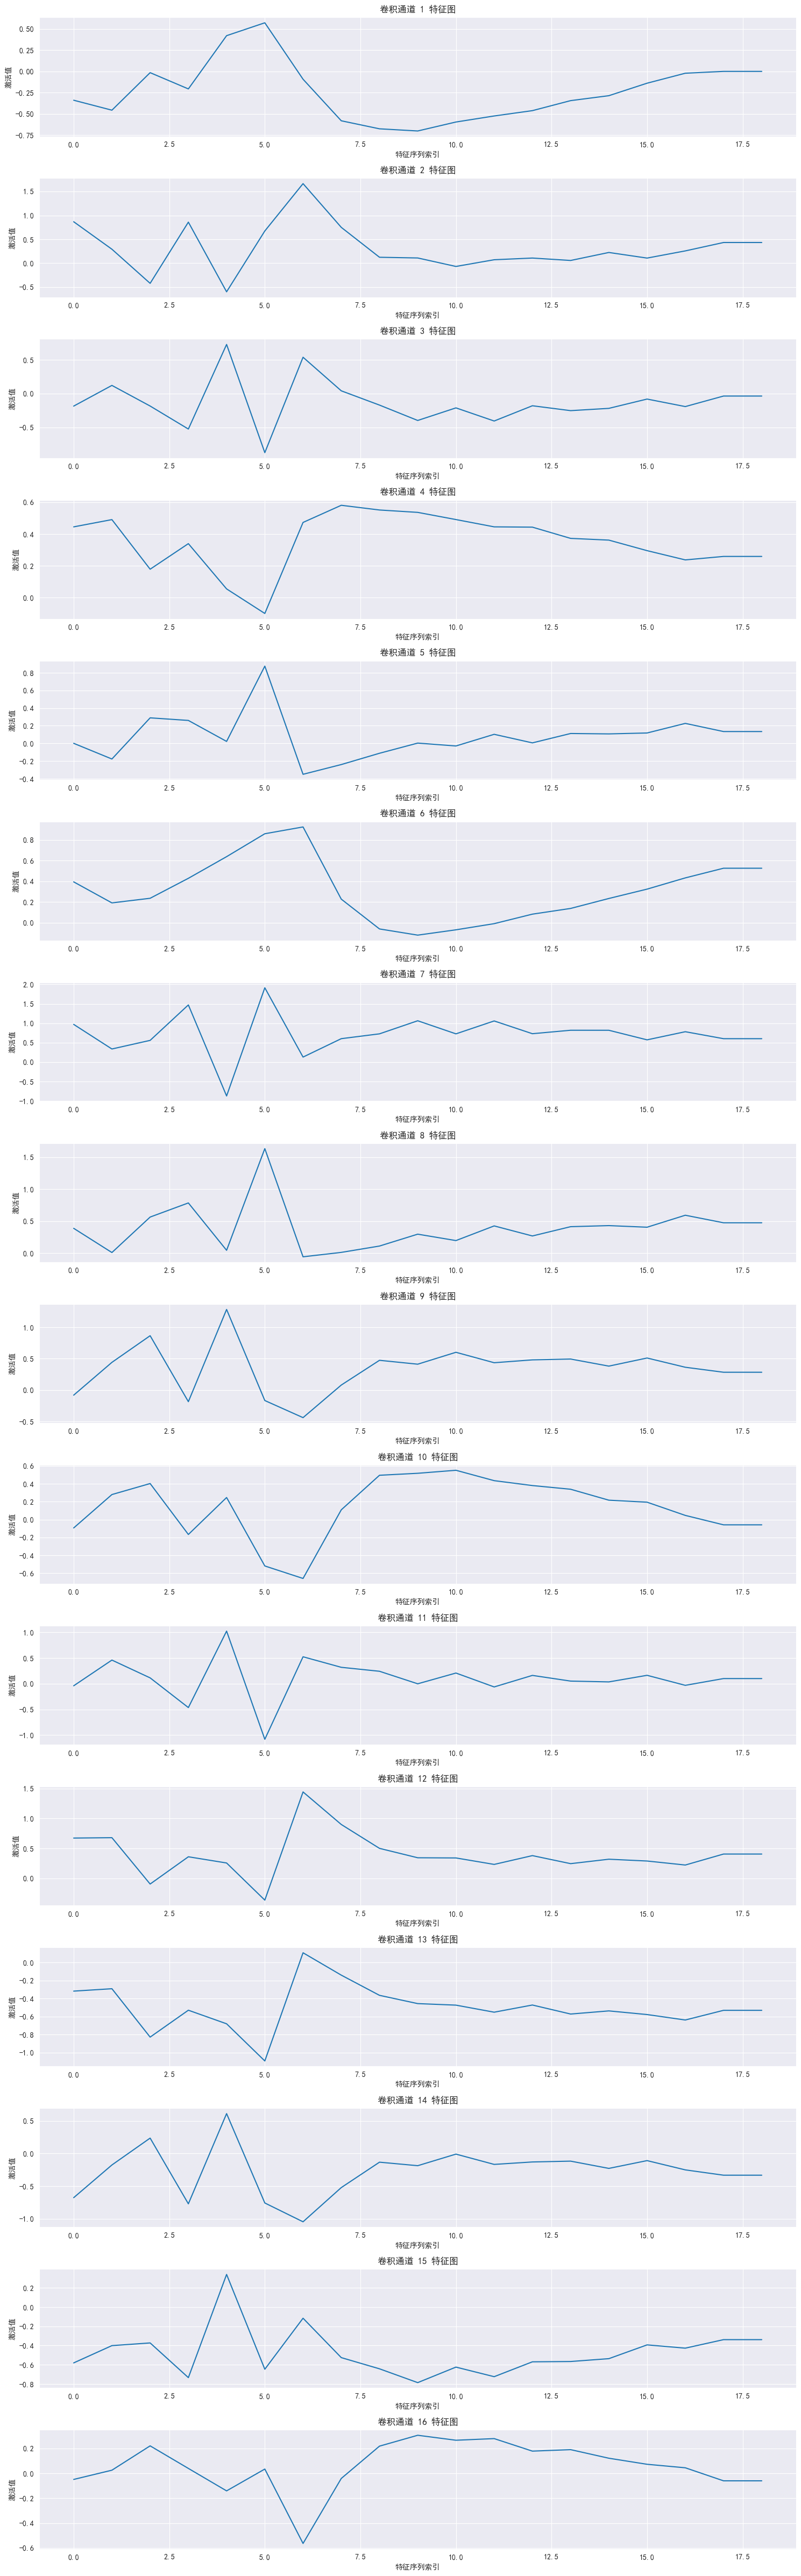

In [22]:
# 单样本预测与卷积特征可视化

import matplotlib.pyplot as plt

# 选择测试集样本索引
sample_idx = 0
sample = torch.tensor(X_test_tgt[sample_idx], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# 模型预测
model_tgt.eval()
with torch.no_grad():
    pred = model_tgt(sample)
    pred_label = le_tgt.inverse_transform([pred.argmax().item()])

print(f"测试集样本索引 {sample_idx} 的预测类别:", pred_label[0])
print(f"真实类别: {y_test_tgt[sample_idx]}")

# 可视化卷积层特征
# 获取第一层卷积输出
first_conv_layer = model_tgt.conv_layers[0]  # 第一个 Conv1d
with torch.no_grad():
    conv_features = first_conv_layer(sample).cpu().squeeze(0)  # (C, L)

num_features = conv_features.shape[0]

plt.figure(figsize=(15, 3 * num_features))
for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.plot(conv_features[i].numpy())
    plt.title(f"卷积通道 {i + 1} 特征图")
    plt.xlabel("特征序列索引")
    plt.ylabel("激活值")
plt.tight_layout()
plt.show()


In [23]:
# 批量预测目标域测试集
y_pred_batch = []
model_tgt.eval()
with torch.no_grad():
    for X_batch, _ in DataLoader(BearingDataset(X_test_tgt, y_test_enc_tgt), batch_size=32):
        X_batch = X_batch.to(device)
        outputs = model_tgt(X_batch)
        preds = outputs.argmax(dim=1)
        y_pred_batch.extend(preds.cpu().numpy())

# 计算准确率
accuracy = np.mean(y_pred_batch == y_test_enc_tgt)
print(f"目标域测试集整体准确率: {accuracy:.4f}")


目标域测试集整体准确率: 0.7879


In [24]:
import random

sample_indices = random.sample(range(len(X_test_tgt)), 5)

for idx in sample_indices:
    sample = torch.tensor(X_test_tgt[idx], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model_tgt(sample)
        pred_label = le_tgt.inverse_transform([pred.argmax().item()])
    print(f"样本索引 {idx} - 真实类别: {y_test_tgt[idx]}, 预测类别: {pred_label[0]}")


样本索引 2 - 真实类别: 外圈故障, 预测类别: 外圈故障
样本索引 16 - 真实类别: 内圈故障, 预测类别: 滚动体故障
样本索引 32 - 真实类别: 外圈故障, 预测类别: 外圈故障
样本索引 21 - 真实类别: 外圈故障, 预测类别: 外圈故障
样本索引 24 - 真实类别: 外圈故障, 预测类别: 外圈故障


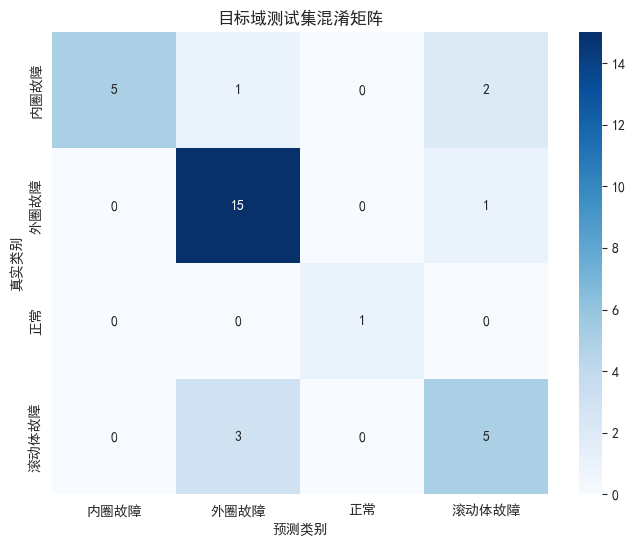

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_enc_tgt, y_pred_batch)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_tgt.classes_, yticklabels=le_tgt.classes_)
plt.xlabel("预测类别")
plt.ylabel("真实类别")
plt.title("目标域测试集混淆矩阵")
plt.show()
